In [8]:
!pip install tqdm
!pip install scikit-learn

You are using pip version 9.0.3, however version 23.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.3, however version 23.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.svm import SVC

## Data loading

In [10]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("E:\DataChallenge\Owkin")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir  / "supplementary_data_fLolZIs" / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data_fLolZIs" / "supplementary_data" / "test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print("Training data dimensions: {}".format(df_train.shape))  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


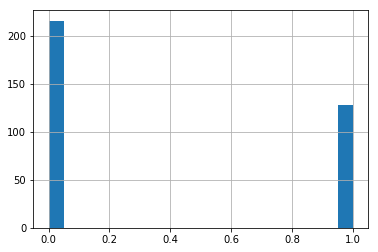

In [11]:
df_train['Target'].hist(bins=20) 
plt.show()

The datas are balanced

# Dealing with images

The following code aims to load and manipulate the images provided as part of  this challenge.

## Scanning images paths on disk

This operation can take up to 5 minutes.

In [12]:
train_images_dir = data_dir / "train_input" / "train_input" / "images"
train_images_files = list(train_images_dir.rglob("*.jpg"))

test_images_dir = data_dir / "test_input" / "test_input" / "images"
test_images_files = list(test_images_dir.rglob("*.jpg"))

print(
    "Number of images\n"
    "-----------------\n"
    "Train: {}\n" # 344 x 1000 = 344,000 tiles
    "Test: {}\n"  # 149 x 1000 = 149,000 tiles
    "Total: {}\n".format(len(train_images_files), len(test_images_files), len(train_images_files) + len(test_images_files))
)

Number of images
-----------------
Train: 344000
Test: 148999
Total: 492999



## Reading

Now we can load some of the `.jpg` images for a given sample, say `ID_001`.

In [13]:
ID_001_tiles = [p for p in train_images_files if 'ID_001' in p.name]

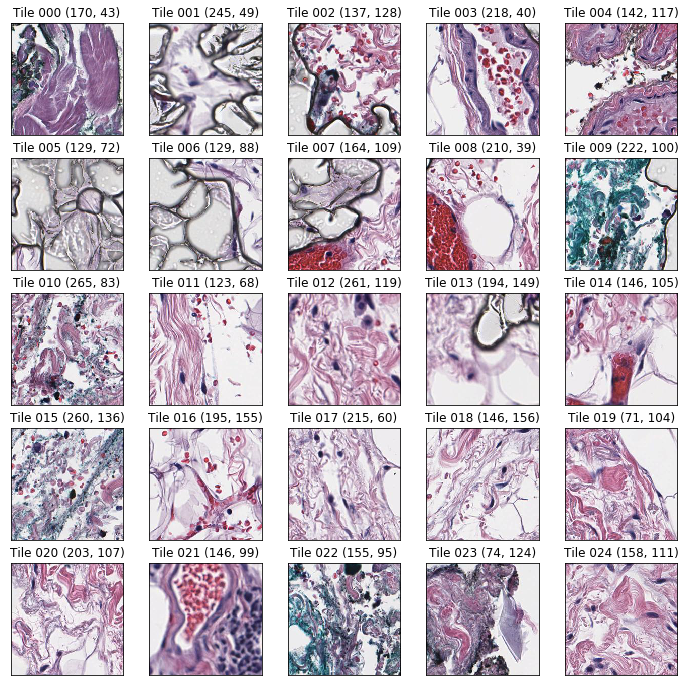

In [14]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(12, 12)

for i, img_file in enumerate(ID_001_tiles[:25]):
    # get the metadata from the file path
    _, metadata = str(img_file).split("tile_")
    id_tile, level, x, y = metadata[:-4].split("_")
    img = plt.imread(img_file)
    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Tile {} ({}, {})".format(id_tile, x, y))
plt.show()

## Mapping with features

Note that the coordinates in the features matrices and tiles number are aligned.

In [15]:
sample = "ID_001.npy"
_features = np.load(train_features_dir / sample)
coordinates, features = _features[:, :3], _features[:, 3:]
print("xy features coordinates")
coordinates[:10, 1:].astype(int)

xy features coordinates


array([[170,  43],
       [245,  49],
       [137, 128],
       [218,  40],
       [142, 117],
       [129,  72],
       [129,  88],
       [164, 109],
       [210,  39],
       [222, 100]])

In [16]:
print(
    "Tiles numbering and features coordinates\n"
)
[tile.name for tile in ID_001_tiles[:10]]

Tiles numbering and features coordinates



['ID_001_tile_000_17_170_43.jpg',
 'ID_001_tile_001_17_245_49.jpg',
 'ID_001_tile_002_17_137_128.jpg',
 'ID_001_tile_003_17_218_40.jpg',
 'ID_001_tile_004_17_142_117.jpg',
 'ID_001_tile_005_17_129_72.jpg',
 'ID_001_tile_006_17_129_88.jpg',
 'ID_001_tile_007_17_164_109.jpg',
 'ID_001_tile_008_17_210_39.jpg',
 'ID_001_tile_009_17_222_100.jpg']

## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [138]:
X_train_ref = []
y_train_ref = []
centers_train_ref = []
patients_train_ref = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train_ref.append(np.mean(features,axis=0))
    y_train_ref.append(label)
    centers_train_ref.append(center)
    patients_train_ref.append(patient)
    
# convert to numpy arrays
X_train_ref = np.array(X_train_ref)
y_train_ref = np.array(y_train_ref)
centers_train_ref = np.array(centers_train_ref)
patients_train_ref = np.array(patients_train_ref)

100%|██████████| 344/344 [01:03<00:00,  5.44it/s]


In [142]:
X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    features_extracted=np.array([features[:,i] for i in range(features.shape[1]) if i not in to_drop_index_unique]).T
    X_train.append(np.mean(features_extracted,axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

# convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

100%|██████████| 344/344 [01:02<00:00,  5.51it/s]


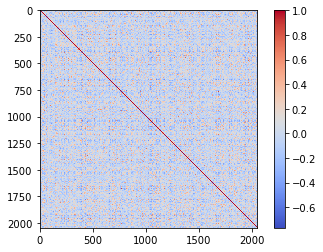

In [139]:
# Correlation matrix
X_train_label=np.insert(X_train_ref,X_train_ref.shape[1],y_train_ref,axis=1)
corr_matrix=np.corrcoef(X_train_ref, rowvar=False)

# Tracer la matrice de corrélation
fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap="coolwarm")

# Ajouter une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

plt.figure()
# plt.plot(corr_matrix[:,-1])
# Afficher le plot
plt.show()

In [140]:
# Feature selection using the correlation matrix 

# Remove diagonal values
corr_matrix = corr_matrix - np.diagflat(np.diag(corr_matrix))

# Define a correlation threshold for features
corr_threshold = 0.8

# Find features with a correlation above the threshold
to_drop_features = []
for i in range(len(corr_matrix)):
    for j in range(i):
        if abs(corr_matrix[i, j]) > corr_threshold:
            to_drop_features.append(j)

print(len(to_drop_features))
# Define a correlation threshold for the target variable
target_corr_threshold = 0.1

# Calculate the correlation between each feature and the target variable
feature_target_corr = []
for i in range(X_train_ref.shape[1]):
    corr = np.corrcoef(X_train_ref[:, i], y_train_ref)[0, 1]
    feature_target_corr.append(corr)

# Find features with a correlation below the threshold
to_drop_target = []
for i in range(len(feature_target_corr)):
    if abs(feature_target_corr[i]) < target_corr_threshold:
        to_drop_target.append(i)

print(len(to_drop_target))
# Get the index of the features to drop
to_drop_index = to_drop_features + to_drop_target

to_drop_index_unique=list(set(to_drop_index))
# print(to_drop_index_unique)
print(len(corr_matrix))
print(len(to_drop_index))
print(len(to_drop_index_unique))

# Get the index of features that are highly correlated with each other
highly_corr_index = np.where(corr_matrix > corr_threshold)
highly_corr_index = [(i, j) for i, j in zip(highly_corr_index[0], highly_corr_index[1]) if i > j]

# Print the index of features to drop and highly correlated features
print("Features to drop:", to_drop_index)
print("Highly correlated features:", highly_corr_index)


264
1604
2048
1868
1634
Features to drop: [243, 94, 307, 363, 242, 210, 286, 435, 451, 429, 327, 471, 241, 242, 242, 504, 579, 253, 655, 170, 562, 508, 637, 86, 170, 358, 732, 669, 451, 650, 242, 504, 508, 270, 282, 545, 562, 738, 602, 115, 7, 80, 230, 642, 80, 301, 269, 745, 562, 505, 562, 738, 978, 240, 510, 873, 207, 327, 646, 957, 62, 141, 910, 302, 419, 522, 187, 253, 227, 358, 786, 1045, 156, 650, 832, 270, 282, 479, 562, 738, 873, 982, 995, 298, 602, 718, 891, 314, 111, 242, 398, 508, 751, 866, 242, 504, 642, 652, 866, 362, 1086, 1163, 26, 866, 526, 398, 1199, 536, 233, 494, 1056, 301, 944, 718, 62, 451, 1291, 243, 811, 928, 332, 902, 1324, 1368, 1429, 650, 1102, 1140, 637, 1067, 891, 1134, 1401, 327, 554, 1000, 1000, 240, 68, 743, 429, 444, 1118, 468, 26, 188, 242, 398, 866, 1163, 1181, 1199, 1224, 1345, 536, 1291, 1406, 1497, 500, 429, 1315, 1558, 957, 1549, 499, 701, 307, 369, 413, 80, 26, 524, 1138, 1067, 307, 369, 1645, 358, 616, 675, 765, 1324, 1597, 1318, 1685, 1303, 151,

In [141]:

features_filtered = np.delete(features, to_drop_index_unique, axis=1)

X_train_filtered=[]
for sample, label, center, patient in tqdm(
    df_train[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    X_train_filtered.append(np.mean(features_filtered,axis=0))

# convert to numpy arrays
X_train_filtered = np.array(X_train_filtered)
print(X_train_filtered[2,:])

# convert to a 2D-array to use it
# X_train_filtered = X_train_filtered.reshape(X_train_filtered.shape[0], -1)

print(X_train_filtered.shape)
print(X_train_ref.shape)
print(y_train_ref.shape)

100%|██████████| 344/344 [00:00<00:00, 4568.05it/s]

[  1.11909300e-01   7.13139921e-02   3.93227935e-02   4.16896269e-02
   3.88513990e-02   6.61528334e-02   6.11477569e-02   7.32000470e-02
   4.61741211e-03   9.74962662e-04   1.28109884e-02   4.36366070e-03
   1.39900476e-01   8.11822130e-04   6.84655178e-03   4.81600724e-02
   4.17972654e-02   3.84759828e-02   8.13613608e-02   1.88645590e-02
   5.51418262e-03   3.52268443e-02   2.04924699e-02   2.22307583e-03
   7.36709237e-02   1.73076359e-03   5.65076433e-02   1.16510481e-01
   1.33575918e-02   1.37755096e-01   1.16536453e-01   1.09839365e-01
   1.69049069e-01   3.26987845e-03   1.85545126e-03   1.16981626e-01
   3.32617405e-04   1.32686635e-02   4.75970842e-03   3.69947590e-02
   1.61188487e-02   5.04539348e-03   6.66751293e-03   1.35058686e-01
   2.13029291e-02   1.08241037e-01   1.84604863e-03   2.12159269e-02
   1.29064292e-01   1.27817448e-02   4.48453762e-02   3.42211947e-02
   4.93886620e-02   5.12778610e-02   1.15783475e-01   2.14651674e-02
   5.18815890e-02   5.93507253e-02

Idea (TO DO): Select the most relevant features from averaging and then remove averaging to have the selected features on all tiles.

Feature selection :
    - Correlation analysis: you can use the correlation matrix to identify features that have a high correlation with the target variable. Features with a high correlation generally have more impact on the target variable.
    - Analysis of variance (ANOVA): you can use ANOVA to measure the importance of each feature by comparing the variance between groups of data. Features with higher variance are generally more important.
    - Model selection: you can use model selection algorithms such as Lasso, Ridge or Elastic Net to select the most relevant features according to their contribution to model accuracy.
    - Principal Component Analysis (PCA): you can use PCA to reduce the dimensionality of the data and identify the features that have the greatest impact on the variance of the data.
    
Test them

## 5-fold cross validation

In [94]:
# /!\ we perform splits at the patient level so that all samples from the same patient
# are found in the same split

patients_unique = np.unique(patients_train)
y_unique = np.array(
    [np.mean(y_train[patients_train == p]) for p in patients_unique]
)
centers_unique = np.array(
    [centers_train[patients_train == p][0] for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    "{} unique samples\n"
    "{} unique patients\n"
    "{} unique centers".format(len(X_train), len(patients_unique), len(np.unique(centers_unique)))
) 

Training set specifications
---------------------------
344 unique samples
305 unique patients
3 unique centers


In [143]:
aucs = []
models = []
print(X_train.shape)
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        model = RandomForestClassifier(n_estimators=200, max_depth=12)
        # fit it
        model.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = model.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print("AUC on split {} fold {}: {:.3f}".format(k, fold, auc))
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        models.append(model)
        fold += 1
    print("----------------------------")
print(
    "5-fold cross-validated AUC averaged over {} repeats: {:.3f} ({:.3f})".format(k+1, np.mean(aucs), np.std(aucs))
)

(344, 414)
AUC on split 0 fold 0: 0.692
AUC on split 0 fold 1: 0.649
AUC on split 0 fold 2: 0.775
AUC on split 0 fold 3: 0.661
AUC on split 0 fold 4: 0.822
----------------------------
AUC on split 1 fold 0: 0.744
AUC on split 1 fold 1: 0.783
AUC on split 1 fold 2: 0.665
AUC on split 1 fold 3: 0.651
AUC on split 1 fold 4: 0.804
----------------------------
AUC on split 2 fold 0: 0.670
AUC on split 2 fold 1: 0.682
AUC on split 2 fold 2: 0.792
AUC on split 2 fold 3: 0.759
AUC on split 2 fold 4: 0.596
----------------------------
AUC on split 3 fold 0: 0.740
AUC on split 3 fold 1: 0.740
AUC on split 3 fold 2: 0.763
AUC on split 3 fold 3: 0.668
AUC on split 3 fold 4: 0.697
----------------------------
AUC on split 4 fold 0: 0.705
AUC on split 4 fold 1: 0.787
AUC on split 4 fold 2: 0.756
AUC on split 4 fold 3: 0.708
AUC on split 4 fold 4: 0.631
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.718 (0.059)


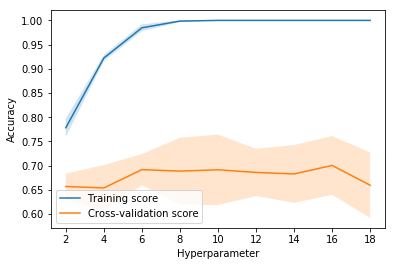

In [147]:
# Draw validation curve

model = RandomForestClassifier(n_estimators=200, max_depth=12)
    
# Define the parameter range for the number of trees
param_range = np.arange(1, 300, 5)
# Define the parameter range for the depth
param_range = np.arange(2, 20, 2)

# Calculate the training and validation scores for different numbers of trees
train_scores, val_scores = validation_curve(model, X_train, y_train, param_name="max_depth", param_range=param_range, cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label="Training score")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(param_range, val_mean, label="Cross-validation score")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("Hyperparameter")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

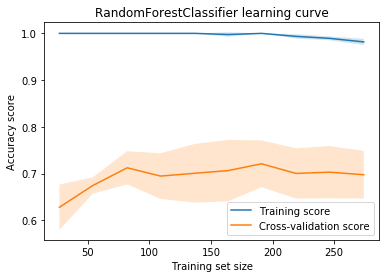

In [134]:
# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the training and validation scores for different training set sizes
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("RandomForestClassifier learning curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.show()

***SVM architecture***

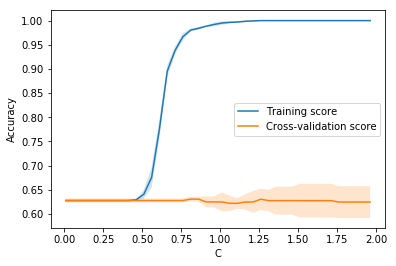

In [43]:
# Draw validation curve

svm_model = SVC(kernel='rbf', C=0.8, gamma=0.6, random_state=1)

# Define the parameter range C
param_range1 = np.arange(0.01, 2, 0.05)
# Define the parameter range gamma
param_range2 = np.arange(0, 1, 0.02)

# Calculate the training and validation scores for different numbers of trees
param_name="C"; param_range=param_range1
train_scores, val_scores = validation_curve(svm_model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, label="Training score")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(param_range, val_mean, label="Cross-validation score")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel(param_name)
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

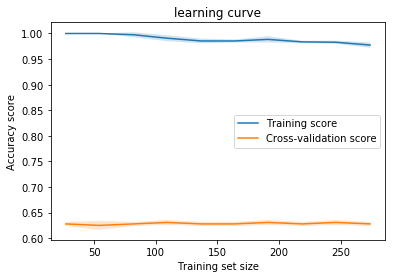

In [44]:
# Define the range of training set sizes to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the training and validation scores for different training set sizes
train_sizes, train_scores, val_scores = learning_curve(svm_model, X_train, y_train, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label="Cross-validation score")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("learning curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.show()

In [32]:
aucs = []
models = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # instantiate the model
        model = SVC(kernel='rbf', C=0.8, gamma=0.6, random_state=1,probability=True)
        # fit it
        model.fit(X_fold_train, y_fold_train)
        # get the predictions (1-d probability)
        preds_val = model.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print("AUC on split {} fold {}: {:.3f}".format(k, fold, auc))
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        models.append(model)
        fold += 1
    print("----------------------------")
print(
    "5-fold cross-validated AUC averaged over {} repeats: {:.3f} ({:.3f})".format(k+1, np.mean(aucs), np.std(aucs))
)

AUC on split 0 fold 0: 0.590
AUC on split 0 fold 1: 0.546
AUC on split 0 fold 2: 0.632
AUC on split 0 fold 3: 0.555
AUC on split 0 fold 4: 0.597
----------------------------
AUC on split 1 fold 0: 0.639
AUC on split 1 fold 1: 0.605
AUC on split 1 fold 2: 0.607
AUC on split 1 fold 3: 0.496
AUC on split 1 fold 4: 0.644
----------------------------
AUC on split 2 fold 0: 0.573
AUC on split 2 fold 1: 0.632
AUC on split 2 fold 2: 0.696
AUC on split 2 fold 3: 0.614
AUC on split 2 fold 4: 0.488
----------------------------
AUC on split 3 fold 0: 0.646
AUC on split 3 fold 1: 0.594
AUC on split 3 fold 2: 0.515
AUC on split 3 fold 3: 0.616
AUC on split 3 fold 4: 0.571
----------------------------
AUC on split 4 fold 0: 0.585
AUC on split 4 fold 1: 0.370
AUC on split 4 fold 2: 0.663
AUC on split 4 fold 3: 0.578
AUC on split 4 fold 4: 0.535
----------------------------
5-fold cross-validated AUC averaged over 5 repeats: 0.583 (0.066)


***NN architecture***

In [54]:
import tensorflow as tf

# Architecture NN
NN_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = NN_model.fit(X, y, epochs=50, batch_size=32)


ImportError: No module named 'tensorflow'

In [ ]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the learning curve for the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the learning curve for the training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
aucs = []
models = []
# 5-fold CV is repeated 5 times with different random states
for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        # retrieve the indexes of the samples corresponding to the
        # patients in `train_idx_` and `test_idx_`
        train_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[train_idx_])
        ]
        val_idx = np.arange(len(X_train))[
            pd.Series(patients_train).isin(patients_unique[val_idx_])
        ]
        # set the training and validation folds
        X_fold_train = X_train[train_idx]
        y_fold_train = y_train[train_idx]
        X_fold_val = X_train[val_idx]
        y_fold_val = y_train[val_idx]
        # fit it
        NN_model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_val,y_fold_val))
        # get the predictions (1-d probability)
        preds_val = model.predict_proba(X_fold_val)[:, 1]
        # compute the AUC score using scikit-learn
        auc = roc_auc_score(y_fold_val, preds_val)
        print("AUC on split {} fold {}: {:.3f}".format(k, fold, auc))
        aucs.append(auc)
        # add the logistic regression to the list of classifiers
        models.append(model)
        fold += 1
    print("----------------------------")
print(
    "5-fold cross-validated AUC averaged over {} repeats: {:.3f} ({:.3f})".format(k+1, np.mean(aucs), np.std(aucs))
)

TO DO

1. Plot validation curve to select hyperparameters
2. Plot learning curve to check bias/variance
3. Test other methods (SVM, NN)
4. Test using all selected features for each tile
5. To overcome the problems inherent in the challenge, it is necessary to limit overfitting by limiting the complexity of the model and using regularization methods



# Submission

Now we evaluate the previous models trained through cross-validation so that to produce a submission file that can directly be uploaded on the data challenge platform.

## Data processing

In [144]:
X_test = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    features_extracted=np.array([features[:,i] for i in range(features.shape[1]) if i not in to_drop_index_unique]).T
    X_test.append(np.mean(features_extracted,axis=0))

X_test = np.array(X_test)

100%|██████████| 149/149 [00:35<00:00,  4.17it/s]


## Inference

In [145]:
preds_test = 0
# loop over the classifiers
for model in models:
    preds_test += model.predict_proba(X_test)[:, 1]
# and take the average (ensembling technique)
preds_test = preds_test / len(models)

## Saving predictions

In [146]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": preds_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / "benchmark_test_output.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.585399
1,ID_004.npy,0.463132
2,ID_008.npy,0.506908
3,ID_009.npy,0.436000
4,ID_010.npy,0.256795
